In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import PIL
import urllib
from tqdm.notebook import tqdm

# import timm
# import fastai.vision.all as fastai
# from fastai.callback.schedule import Learner

# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
%load_ext tensorboard

seed = 42
np.random.seed(seed + 1)
torch.manual_seed(seed)

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'
    return device

device = get_device()

print(f'device: {device}')

device: mps


In [2]:
def get_mnist_data(path='~/data', as_rgb=False, download=False, transforms=[]):
    reshape = lambda x: x
    if as_rgb:
        reshape = lambda x: x.repeat(3, 1, 1)
    train_data = torchvision.datasets.MNIST(
        path,
        download=download,
        train=True,
        transform=torchvision.transforms.Compose([
            *transforms,
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(reshape),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    )
    test_data = torchvision.datasets.MNIST(
        path,
        download=download,
        train=False,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(reshape),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    )
    
    return train_data, test_data

def get_optimizer(model, optimizer='sgd', lr=0.001, weight_decay=0, momentum=0, betas=(0.9, 0.999), eps=1e-8):
    if optimizer == 'sgd':
        opt = torch.optim.SGD(
            model.parameters(),
            lr=lr, 
            weight_decay=weight_decay, 
            momentum=momentum
        )
    if optimizer == 'adam':
        opt = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=betas,
            eps=eps
        )
    return opt

def train_model(train_data, model, opt, loss_fn, test_data=None, num_epochs=1000, plot_loss=True, batch_size=32,
               tensorboard=False, print_loss=True, show_batches_bar=False):
    if tensorboard:
        writer = SummaryWriter()
    losses = []
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    if test_data is not None:
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        batch_losses = []
        batch_correct = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        for X, y in iterator:
            X = X.to(device)
            y = y.to(device)
            opt.zero_grad()
            yhat = model(X)
            loss = loss_fn(yhat, y)
            loss.backward()
            opt.step()
            batch_losses.append(float(loss)* batch_size)
            batch_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
        train_loss = sum(batch_losses) / len(train_data)
        train_acc = sum(batch_correct) / len(train_data)
        losses.append(train_loss)
        

        if test_data is not None:
            model = model.eval()
            batch_losses = []
            batch_correct = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for X, y in iterator:
                X = X.to(device)
                y = y.to(device)
                opt.zero_grad()
                yhat = model(X)
                loss = loss_fn(yhat, y)
                batch_losses.append(float(loss) * batch_size)
                batch_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
            test_loss = sum(batch_losses) / len(test_data)
            test_acc = sum(batch_correct) / len(test_data)
        else:
            test_loss = -999
            test_acc = -999

        if tensorboard:
            writer.add_scalar("Training Loss", train_loss, epoch+1)
            writer.add_scalar("Training Accuracy", train_acc, epoch+1)
            writer.add_scalar("Test Loss", test_loss, epoch+1)
            writer.add_scalar("Test Accuracy", test_acc, epoch+1)
        if print_loss:
            s1 = f'epoch: {epoch+1: <3}   ' 
            s2 = f'train loss: {round(train_loss, 4): <6}   train acc: {round(train_acc, 4): <6}   ' 
            s3 = f'test loss: {round(test_loss, 4): <6}   test acc: {round(test_acc, 4): <6}'
            print(s1 + s2 + s3)
    if plot_loss:
        plt.plot(range(len(losses)), losses)
    if tensorboard:
        writer.flush()
        writer.close()
    return model

def get_n_params(model):
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return n_params

def eval_model(model, X_train, y_train, X_test, y_test):
    model = model.eval().to('cpu')
    y_pred_train = model(X_train).argmax(dim=1)
    y_pred_test = model(X_test).argmax(dim=1)
    print(f'train accuracy: {(y_pred_train == y_train).sum() / len(y_train)}')
    print(f'test accuracy: {(y_pred_test == y_test).sum() / len(y_test)}')

In [3]:
train_data, test_data = get_mnist_data(path='~/data', as_rgb=True, download=False)

In [4]:
train_data.data.shape, train_data.targets.shape, test_data.data.shape, test_data.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [5]:
X_train = torch.stack([x for x,y in train_data]).float()
y_train = torch.tensor([y for x,y in train_data]).float()
X_test = torch.stack([x for x,y in test_data]).float()
y_test = torch.tensor([y for x,y in test_data]).float()

# Cuda

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 3, 28, 28]), torch.Size([32]))

In [7]:
x.get_device(), y.get_device() # -1 = cpu, 0 = gpu

(-1, -1)

In [8]:
x = x.to(device)
y = y.to(device)

x.get_device(), y.get_device()

(0, 0)

# Transfer Learning

Idea: Large pretrained models trained on lots of data have learned how to extract visual features really well. Take that pretrained model, add a new output layer, and just finetune that new layer on your new data. In a sense, transfer learning gives you a better initialization than starting randomly.

Steps: Given some labeled data and a pretrained model trained on a much bigger dataset,
- Remove the original output layer from that model
- Add one or more new, initialized output layers that matches your number of classes
- Keeping the earlier layers in the pretrained model fixed, finetune just that last layer on your data
- If desired, unfreeze the earlier pretrained layers and finetune those as well

Tip: If just finetuning the last layer, pre-extract the features from the frozen pretrained network to save on computation.

In [9]:
# way too slow on CPU
# freeze all but last 3 layer groups, and replace last fc layer with new random layer

model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
for layer in [model.layer3, model.layer4]:
    for param in layer.parameters():
        param.requires_grad = True

last_layer = model.fc
in_features = last_layer.in_features
out_features = len(test_data.targets.unique())
model.fc = nn.Linear(in_features, out_features)

model = model.to(device)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1     train loss: 0.1227   train acc: 0.9637   test loss: 0.0524   test acc: 0.9844
epoch: 2     train loss: 0.0563   train acc: 0.9838   test loss: 0.0401   test acc: 0.9882
epoch: 3     train loss: 0.0392   train acc: 0.988    test loss: 0.0381   test acc: 0.9887
epoch: 4     train loss: 0.033    train acc: 0.9901   test loss: 0.0352   test acc: 0.989 
epoch: 5     train loss: 0.0269   train acc: 0.9919   test loss: 0.039    test acc: 0.9894


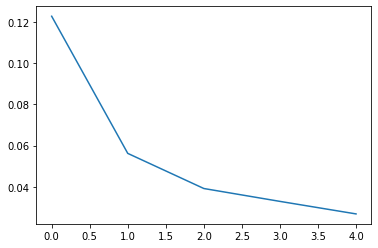

In [10]:
loss_fn = nn.CrossEntropyLoss()
opt = get_optimizer(model, optimizer='adam', lr=0.001, weight_decay=0.)
model = train_model(train_data, model, opt, loss_fn, test_data=test_data, num_epochs=5, batch_size=128)

In [11]:
eval_model(model, X_train, y_train, X_test, y_test)

train accuracy: 0.9952166676521301
test accuracy: 0.9894000291824341


In [12]:
model = model.cpu().eval()

y_pred = model(X_test).argmax(dim=1)
mismatch = (y_pred != y_test)
X_mismatch = X_test[mismatch]
y_mismatch = y_test[mismatch]
y_pred_mismatch = model(X_mismatch).argmax(dim=1)

label: 3 pred: 8


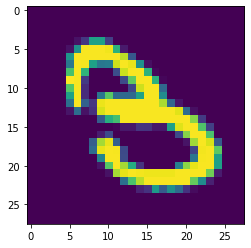

label: 9 pred: 8


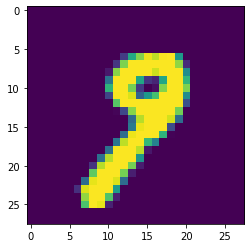

label: 4 pred: 9


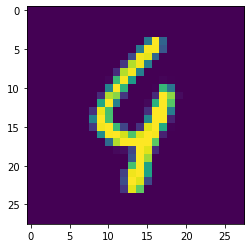

In [13]:
for i in range(3):
    print(f'label: {int(y_mismatch[i])} pred: {int(y_pred_mismatch[i])}')
    plt.imshow(X_mismatch[i].numpy().transpose(1, 2, 0)[:, :, 0])
    plt.show()

# Data Augmentation

Idea: Recognizing objects in an image shouldn't depend on various transformations to the image like rotating, flipping, cropping, scaling, warping, etc. Use these transformations on your training data to artificially increase the size of your training data, and hence improve model performance.

Test Time Augmentation: At test time, for a given test image, use data augmentation on it a few times, make predictions on each augmented image, and average the results together as your true prediction. Can improve test time performance. Used more often in competitions than in production.

Ensembling: Train multiple models on your data, average their predictions at test time, and use that average as your prediction. Due to computational and development costs, this is mostly used in competitions, rarely in production.

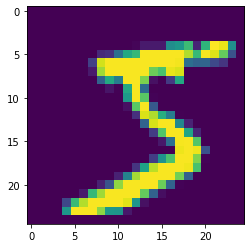

In [14]:
out = torchvision.transforms.RandomCrop(25)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

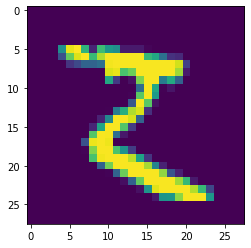

In [15]:
out = torchvision.transforms.RandomHorizontalFlip(p=0.9)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

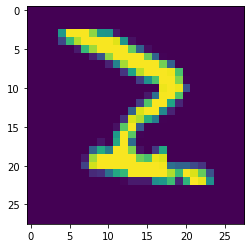

In [16]:
out = torchvision.transforms.RandomVerticalFlip(p=0.9)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

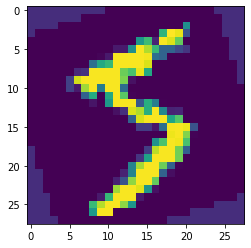

In [17]:
out = torchvision.transforms.RandomRotation(20)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

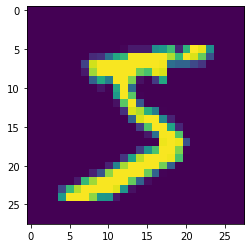

In [18]:
out = torchvision.transforms.RandomPerspective()(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

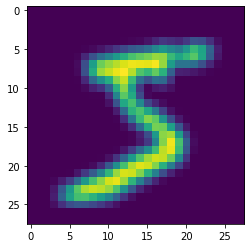

In [19]:
out = torchvision.transforms.GaussianBlur(3)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

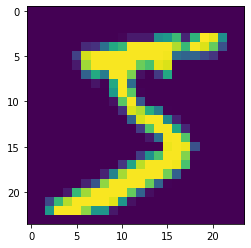

In [20]:
out = torchvision.transforms.CenterCrop(24)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

In [21]:
transforms = [
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomCrop(26),
    torchvision.transforms.Resize(28)
]

train_data, test_data = get_mnist_data(path='~/data', as_rgb=True, download=False, transforms=transforms)
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: /home/paperspace/data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                RandomCrop(size=(26, 26), padding=None)
                Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Lambda()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: /home/paperspace/data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Lambda()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [22]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
for layer in [model.layer3, model.layer4]:
    for param in layer.parameters():
        param.requires_grad = True

last_layer = model.fc
in_features = last_layer.in_features
out_features = len(test_data.targets.unique())
model.fc = nn.Linear(in_features, out_features)

model = model.to(device)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1     train loss: 0.1546   train acc: 0.9536   test loss: 0.0716   test acc: 0.9781
epoch: 2     train loss: 0.077    train acc: 0.9772   test loss: 0.0881   test acc: 0.9726
epoch: 3     train loss: 0.0643   train acc: 0.98     test loss: 0.0727   test acc: 0.9757
epoch: 4     train loss: 0.0541   train acc: 0.9839   test loss: 0.0545   test acc: 0.9813
epoch: 5     train loss: 0.0494   train acc: 0.9853   test loss: 0.0455   test acc: 0.9861


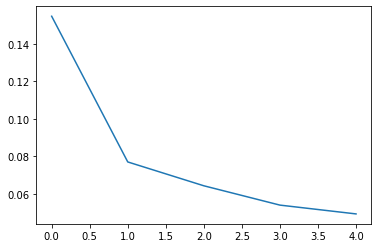

In [23]:
loss_fn = nn.CrossEntropyLoss()
opt = get_optimizer(model, optimizer='adam', lr=0.001, weight_decay=0.)
model = train_model(train_data, model, opt, loss_fn, test_data=test_data, num_epochs=5, batch_size=128)

# Timm and Fastai

In [93]:
import timm
import fastai.vision.all as fastai
from fastai.callback.schedule import Learner

In [76]:
train_data, test_data = get_mnist_data(path='~/data', as_rgb=True, download=False, transforms=[])
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: /home/paperspace/data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Lambda()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: /home/paperspace/data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Lambda()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [94]:
model = timm.create_model('resnet18', pretrained=True, num_classes=10)
model = model.to(device)
get_n_params(model)

11181642

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1     train loss: 0.1107   train acc: 0.9692   test loss: 0.0393   test acc: 0.9887
epoch: 2     train loss: 0.0494   train acc: 0.9868   test loss: 0.029    test acc: 0.9913
epoch: 3     train loss: 0.0372   train acc: 0.9897   test loss: 0.0386   test acc: 0.9893
epoch: 4     train loss: 0.0295   train acc: 0.9918   test loss: 0.0401   test acc: 0.9903
epoch: 5     train loss: 0.027    train acc: 0.9925   test loss: 0.0336   test acc: 0.9907


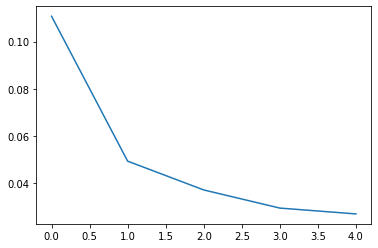

In [95]:
loss_fn = nn.CrossEntropyLoss()
opt = get_optimizer(model, optimizer='adam', lr=0.001, weight_decay=0.)
model = train_model(train_data, model, opt, loss_fn, test_data=test_data, num_epochs=5, batch_size=128)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/paperspace/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(valley=0.0003311311302240938)

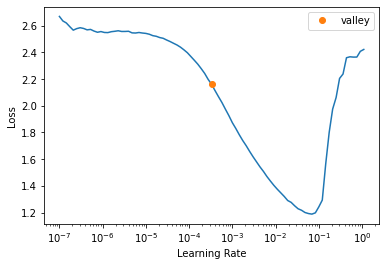

In [83]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)
dls = fastai.DataLoaders(train_loader, test_loader)

model = timm.create_model('resnet18', pretrained=True, num_classes=10)
model = model.to(device)

learn = Learner(dls, model, loss_func=loss_fn, metrics=fastai.accuracy)
# learn.unfreeze()
learn.lr_find()

In [84]:
lr = 0.0003
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.084199,0.054210,0.984800,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.045896,0.029305,0.991500,00:32
1,0.020793,0.023929,0.992700,00:32
2,0.008939,0.019255,0.994800,00:32


In [90]:
learn.freeze_to(-3)

In [92]:
lr = 8e-6
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.006350,0.019973,0.994300,00:32
1,0.005530,0.018088,0.994700,00:32
2,0.004235,0.018334,0.994900,00:32
3,0.005592,0.018062,0.994600,00:32
4,0.003159,0.018306,0.995000,00:32
